In [1]:
%matplotlib inline
import matplotlib as mpl
plt = mpl.pyplot
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0
import numpy as np
import utils

In [2]:
training_features, training_labels, validation_features, validation_labels, words = \
    utils.get_training_data(0.2, onehot=False, standardize=False)
print(training_features.shape, training_labels.shape,
     validation_features.shape, validation_labels.shape)

(16000, 1000) (16000,) (4000, 1000) (4000,)


In [3]:
# Tf-Idf transform
# from sklearn.feature_extraction.text import TfidfTransformer
# tfidf = TfidfTransformer()
# training_features = tfidf.fit_transform(training_features)
# validation_features = tfidf.transform(validation_features)

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
n_estimators = 10000
learning_rate = 0.01
dt = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=n_estimators, 
                        learning_rate=learning_rate)

In [5]:
ada.fit(training_features, training_labels)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.01, n_estimators=10000, random_state=None)

In [18]:
from sklearn.metrics import zero_one_loss
def plot_ada_hist(ada, title='', metric='loss'):
    if metric=='loss':
        metric_fun = lambda x, y: zero_one_loss(x, y)
        label = 'Loss'
    elif metric=='acc':
        metric_fun = lambda x, y: 1-zero_one_loss(x, y)
        label = 'Accuracy'
    else:
        return
    
    ada_acc = np.zeros((n_estimators,))
    for i, pred_labels in enumerate(ada.staged_predict(validation_features)):
        ada_acc[i] = metric_fun(pred_labels, validation_labels)

    ada_acc_train = np.zeros((n_estimators,))
    for i, pred_labels in enumerate(ada.staged_predict(training_features)):
        ada_acc_train[i] = metric_fun(pred_labels, training_labels)

    plt.figure(dpi=300)
    plt.plot(np.arange(n_estimators)+1,
             ada_acc, label='AdaBoost Validation '+label)
    plt.plot(np.arange(n_estimators)+1,
             ada_acc_train, label='AdaBoost Training '+label)
    if metric=='loss':
        plt.semilogy()
    plt.xlabel('Number of iterations')
    plt.ylabel(label)
    plt.legend()
    plt.title(title)
    plt.show()
    plt.clf()

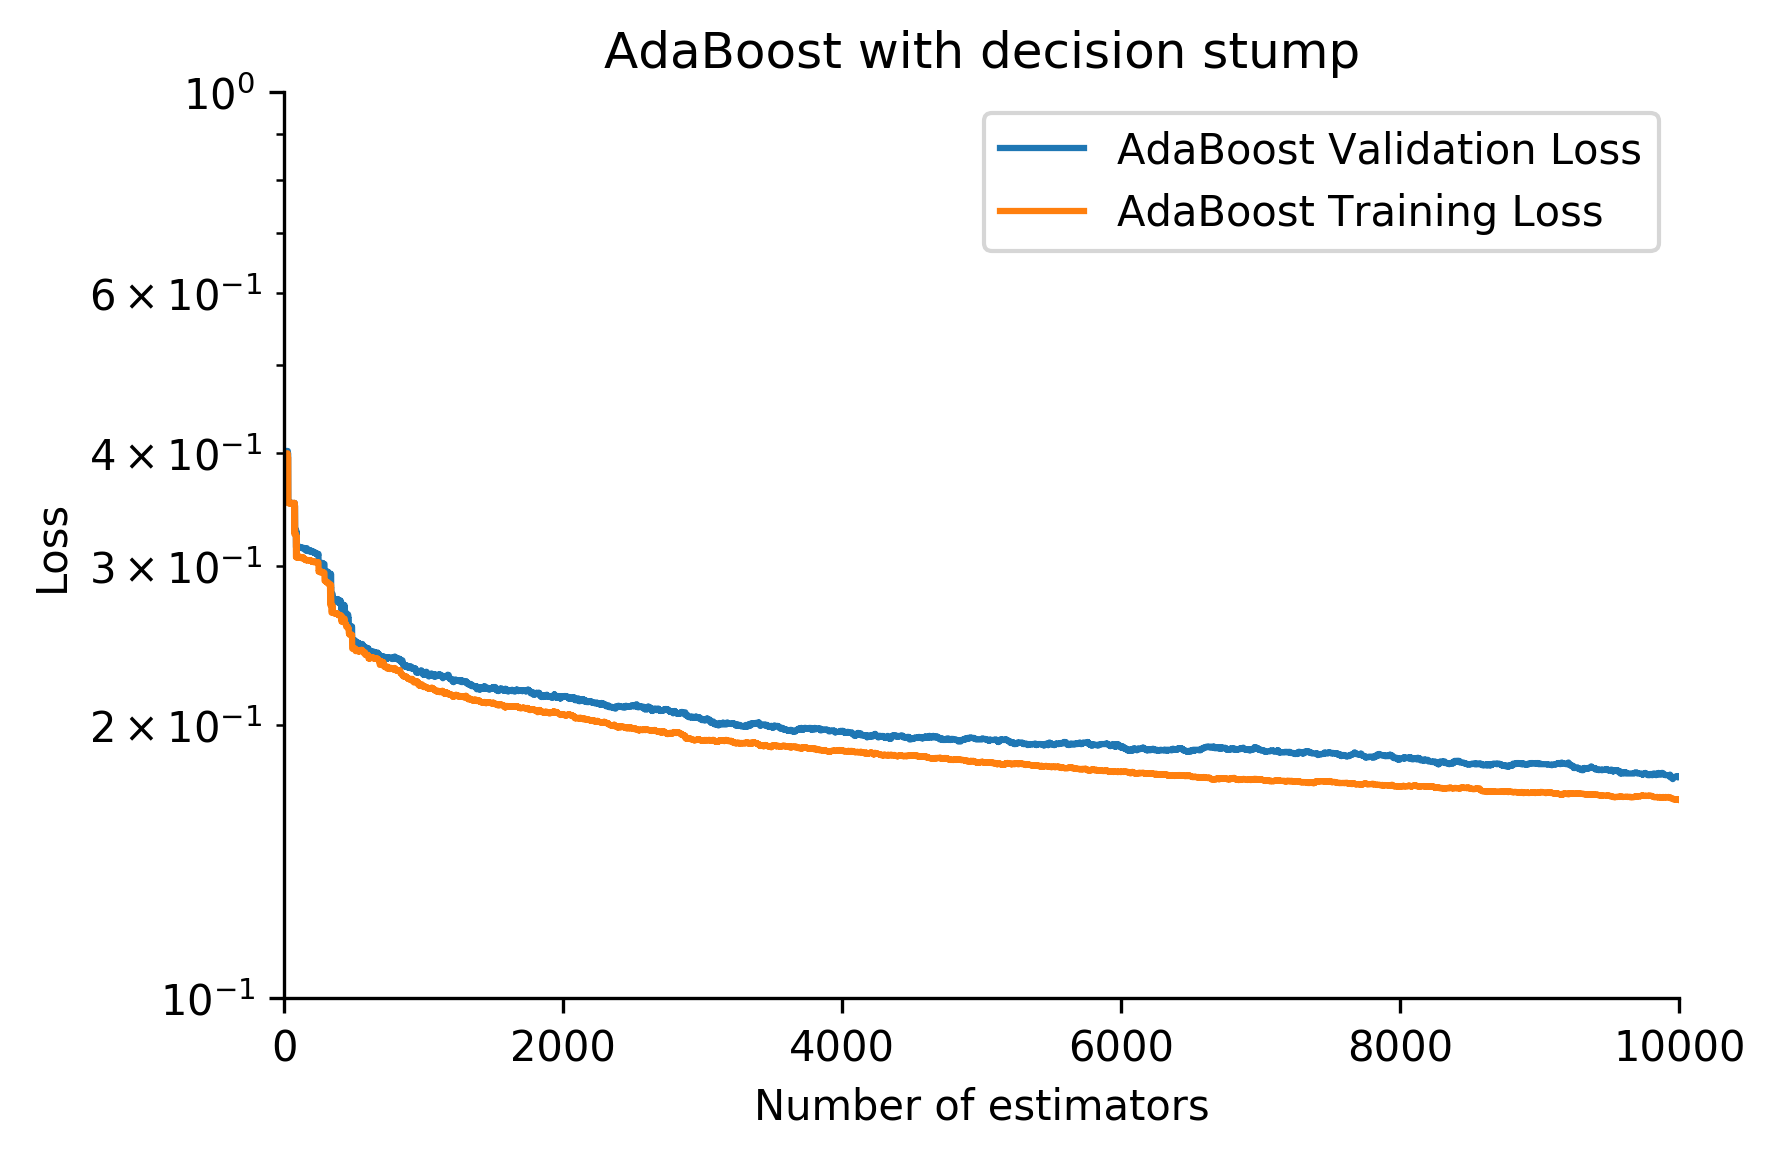

In [17]:
plot_ada_hist(ada, 'AdaBoost with decision stump')

In [19]:
print('The training error is %.4f and validation error is %.4f.'%
     (ada.score(training_features, training_labels),
     ada.score(validation_features, validation_labels)))

The training error is 0.8343 and validation error is 0.8245.


In [31]:
words_weights_sorted_idx = np.argsort(-ada.feature_importances_)
words_weights_sorted = ada.feature_importances_[words_weights_sorted_idx]
words_sorted = [words[k] for k in words_weights_sorted_idx]
print(words_sorted[0:10])
print(words_weights_sorted[0:10])

['great', 'love', 'disappoint', 'excel', 'good', 'poor', 'best', 'bore', 'enjoy', 'worst']
[0.0181 0.0148 0.0135 0.0132 0.0128 0.0113 0.0112 0.0107 0.0094 0.0093]


In [8]:
# Now the final training
training_features1, training_labels1, _, _ = \
    utils.get_training_data(0, onehot=False, standardize=False)
print(training_features1.shape, training_labels1.shape)

(20000, 1000) (20000,)


In [9]:
# Tf-Idf transform
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
training_features1 = tfidf.fit_transform(training_features1)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
n_estimators = 10000
learning_rate = 0.02
dt = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=n_estimators, 
                        learning_rate=learning_rate)
ada.fit(training_features1, training_labels1)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.02, n_estimators=10000, random_state=None)

In [11]:
test_features1 = utils.get_test_data(standardize=False)
test_features1 = tfidf.transform(test_features1)
print(test_features1.shape)

(10000, 1000)


In [12]:
test_labels1 = ada.predict(test_features1)
print(test_labels1.shape, np.min(test_labels1), np.max(test_labels1))

(10000,) 0.0 1.0


In [13]:
utils.save_prediction(test_labels1, 'data/test_labels_ada.txt')